In [11]:
import sys
home = '/home/nina/CopulaGP/'
# To exactly reproduce these results, use an older version of gpytorch (0.3.5) 
# and corresponding version of Copula-GP, eg. commit: 9af5d4
# home = '/media/data0/nkudryas/arch/CopulaGP/' 
sys.path.insert(0, home)
import bvcopula

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

path = '/home/nina/CopulaGP/plos_fig5_data'

# Model fitting and calculations

CPU times: user 12.1 s, sys: 5.58 ms, total: 12.1 s
Wall time: 20.5 s
CPU times: user 33.1 s, sys: 5.19 ms, total: 33.1 s
Wall time: 49.8 s


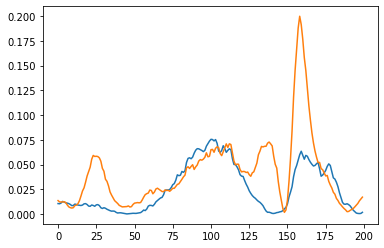

In [8]:
n1,n2 = -2,60 # Index -2 = Licks, 60 = Neuron 60

import torch
device='cuda:0'
with open(f"{path}/ex_{n1}_{n2}_serialized.pkl","rb") as f:
    data = pkl.load(f)
train_x = torch.tensor(data['X'],device=device).float()
train_y = torch.tensor(data['Y'],device=device).float()

import bvcopula

models = []
for likelihoods in [[bvcopula.GaussianCopula_Likelihood()],[bvcopula.GaussianCopula_Likelihood(),bvcopula.ClaytonCopula_Likelihood(rotation='90°')]]:
    waic, model = bvcopula.infer(likelihoods,train_x,train_y,device=device)

    test_x = torch.linspace(0,1,200,device=device).float()
    %time MI = model.MI(test_x,sem_tol=0.01,f_size=25,mc_size=1000)
    models.append(model)

    plt.plot(-MI[1].cpu().numpy())

In [14]:
import torch
import bvcopula

n1, n2 = -2,60

device = "cuda:0"
with open(f"{path}/ex_{n1}_{n2}_serialized.pkl","rb") as f:
    data = pkl.load(f)
train_x = torch.tensor(data['X'],device=device).float()
train_y = torch.tensor(data['Y'],device=device).float()

In [15]:
from torch import Tensor
def _generate_test_samples(model: bvcopula.Mixed_GPInferenceModel, test_x: Tensor) -> Tensor:
    
    with torch.no_grad():
        output = model(test_x)

    #generate some samples
    model.eval()
    with torch.no_grad(), num_likelihood_samples(1):
        gplink = model.likelihood.gplink_function
        likelihoods = model.likelihood.likelihoods
        copulas = [lik.copula for lik in likelihoods]
        rotations = [lik.rotation for lik in likelihoods]
        thetas, mixes = gplink(output.mean)
        test_y = model.likelihood.copula(thetas,mixes,
                    copulas, rotations=rotations,
                    theta_sharing=model.likelihood.theta_sharing).rsample()
        Y_sim = test_y.cpu().detach().numpy()

    return Y_sim

def _get_pearson(X: Tensor, Y: Tensor):
    from scipy.stats import pearsonr

    X = X.squeeze()
    assert np.isclose(X.max(),1.0,atol=1e-4)
    assert np.isclose(X.min(),0.0,atol=1e-4)
    N = int(160/2.5)
    x = np.linspace(0,1,N)
    p = np.empty(N)

    for b in range(N):
        dat = Y[(X>b*(1./N)) & (X<(b+1)*(1./N))]
        if len(dat)>1:
            p[b] = pearsonr(*dat.T)[0]
        
    p = np.convolve(np.array(p), np.ones((4,))/4, mode='valid')    

    return np.stack([x[2:-1]*160,p])

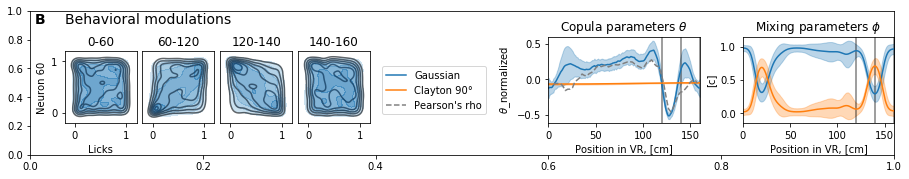

In [17]:
import utils
    
name1, name2 = f"Neuron {data['n1']}", f"Neuron {data['n2']}"
    
name1 = 'Licks'

# visualize the result
from utils import plot_conf as conf2
from gpytorch.settings import num_likelihood_samples
X = data['X']
Y = data['Y']
fig = plt.figure(figsize=(12,2))

ax0 = fig.add_axes([0,0,1,1])

b_mrg = 0.22
top_axes = (fig.add_axes([0.6, b_mrg, 0.175, 0.6]),
            fig.add_axes([0.825, b_mrg,0.175, 0.6]))
bottom_axes = np.array([fig.add_axes([0.04,b_mrg,0.5/6,0.5]),
                        fig.add_axes([0.13,b_mrg,0.5/6,0.5]),
                        fig.add_axes([0.22,b_mrg,0.5/6,0.5]),
                        fig.add_axes([0.31,b_mrg,0.5/6,0.5])])

for a in top_axes:
    a.axvline(120, color='black', alpha=0.5)
    a.axvline(140, color='black', alpha=0.5)
    a.axvline(160, color='black', alpha=0.5)    

# define test set (optionally on GPU)
NSamp = X.shape[0] #by defauls generate as many samples as in training set
testX = np.linspace(0,1,NSamp)
test_x = torch.tensor(testX).float().to(device=device)

Y_sim = _generate_test_samples(model, test_x)

utils.Plot_MixModel_Param_MCMC(top_axes,model,test_x,testX*160,rho=_get_pearson(X,Y),title='')
top_axes[0].set_title(r'Copula parameters $\theta$')
top_axes[1].set_title('Mixing parameters $\phi$')
top_axes[0].legend(loc=(-1.1,0.1))
top_axes[1].legend().set_visible(False)
# top_axes[0].set_ylabel(r"$\theta\_{normalized}$",labelpad=-1)

bottom_axes[0].set_ylabel(name2)
bottom_axes[0].set_xlabel(name1)

interval_ends = [0,60,120,140,160]
# fig.text(0.005,0.91,"A",fontweight="bold",fontsize=14)
# fig.text(0.040,0.91,"Inter-neuronal noise correlations",fontsize=14)
fig.text(0.005,0.91,"B",fontweight="bold",fontsize=14)
fig.text(0.040,0.91,"Behavioral modulations",fontsize=14)
utils.Plot_Copula_Density(bottom_axes, testX.squeeze()*160, Y_sim.squeeze(), interval_ends, shade=True)
utils.Plot_Copula_Density(bottom_axes, X.squeeze()*160, Y, interval_ends, shade=False, color='#073763ff')
for b in bottom_axes[1:]:
    b.set_yticks([])
bottom_axes[0].set_yticks([0,1])
    
plt.subplots_adjust(wspace=0.5)
# fig.savefig(f"{home}/results/example2.pdf")

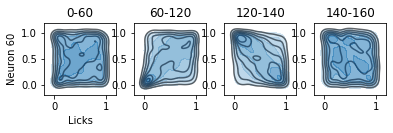

In [14]:
# visualize the result
fig = plt.figure(figsize=(5, 2))

bottom_axes = np.array([fig.add_axes([0,0,0.2,0.5]),
               fig.add_axes([0.25,0,0.2,0.5]),
               fig.add_axes([0.5,0,0.2,0.5]),
               fig.add_axes([0.75,0,0.2,0.5])])

plt.subplots_adjust(hspace=0.5)

bottom_axes[0].set_ylabel(name2)
bottom_axes[0].set_xlabel(name1)

interval_ends = [0,60,120,140,160]
utils.Plot_Copula_Density(bottom_axes, data['Xs'].squeeze()*160, data['Ys'].squeeze(), 
                          interval_ends, shade=True)
utils.Plot_Copula_Density(bottom_axes, data['X'].squeeze()*160, data['Y'], 
                          interval_ends, shade=False, color='#073763ff')

plt.subplots_adjust(wspace=0.5)

# R^2

In [22]:
ints = np.array([0,60,120,140,160])/160
model = models[1]
R = []
N, M = 20, 100
mesh = torch.stack(torch.meshgrid([torch.linspace(0.,1.,M+2)[1:-1], 
                                   torch.linspace(0.,1.,N+2)[1:-1]]),axis=-1).reshape(-1,2).to(device)
for i in range(len(ints)-1):
    mask = (data['X']>ints[i]) & (data['X']<ints[i+1])
    S = data['Y'][mask]
    u_cdf = np.cumsum(np.histogram2d(*S.T,bins=[M+1,N])[0],axis=0)
    ecdf = u_cdf[:-1] / u_cdf.max(axis=0)
    # plt.imshow(ecdf)
    mean = data['X'][mask].mean()
    test_x = (torch.ones(M*N)*mean).float().cuda(device=device)
    with torch.no_grad():
        f = model(test_x).mean
        copula = model.likelihood.get_copula(f)
    ccdf = copula.ccdf(mesh).detach().cpu().numpy().reshape(M,N)
    # plt.imshow(ccdf)
    # base = np.repeat((np.linspace(0,1,N+2)[1:-1]).reshape(-1,1),N,axis=1)
    var_exp = 1 - ((ecdf-ccdf)**2).sum(axis=0)/((ecdf-0.5)**2).sum(axis=0)
    R.append(var_exp.mean())
# plt.plot(np.linspace(0,1,N+2)[1:-1])
# plt.plot(ecdf[:,-4])
# plt.plot(ccdf[:,-4])
# plt.plot(base[:,-4])
R

[0.9863444939795467, 0.9630517859228217, 0.99031782015679, 0.9769964578127748]